<a href="https://colab.research.google.com/github/ccastore/Respiratory-Sound/blob/main/Respiratory_Sound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative study of sampling methods on sound respiratory data set



Pre-processing:
*   Empirical Mode Decomposition (EMD)
*   Discrete wavelet decomposition (DWT)

Features Extracted:


*   Mel Frequency Cepstral Coefficient (MFFC)
*   Gammatone Cepstral Coeficients (GFCC)
*   CepstralFeatures (CD) 

Clasifiers:

*   Quadratic Discriminant (QD)
*   Multilayer Perceptron (MLP)
*   Convolutional Neural Network (CNN)
*   Recurrent Neural Network (RNN)

Sampling Methods:

*   Random Over Sampling (ROS)
*   Synthetic Minority Over-sampling Technique (SMOTE)
*   Synthetic Minority Over-sampling Technique- Willson Edition (SMOTE-ENN)
*   Synthetic Minority Over-sampling Technique- Border Line (SMOTE-BL)
*   Adaptive Synthetic Sampling (ADASYN)
*   Data Augmentation
 *  Loudness augmentation
 *  Mask augmentation
 *  Shift augmentation
 *  Speed augmentation



In [1]:
#Modules
import numpy as np
import librosa as lb
import tensorflow as tf
import os

from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import tabulate

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, cohen_kappa_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN

!pip install audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, TimeMask

!pip install -U spafe
from spafe.features import gfcc

from google.colab import drive 
drive.mount('/content/drive')

     |████████████████████████████████| 77 kB 2.9 MB/s 
Mounted at /content/drive


Data Collector          : 100%|███████████████████| 6898/6898 [00:00<00:00, 162732.13it/s]


Feature Extraction Train: 100%|█████████████████████| 13731/13731 [20:41<00:00, 11.06it/s]


Feature Extraction Test : 100%|███████████████████████| 1271/1271 [00:34<00:00, 36.97it/s]



Sampling_method         : COMPLETE

RNN training

Epoch 1/50
215/215 [==============================] - 189s 807ms/step - loss: 0.6534 - accuracy: 0.7003 - val_loss: 1.5044 - val_accuracy: 0.0409 - lr: 0.0010
Epoch 2/50
215/215 [==============================] - 173s 807ms/step - loss: 0.3730 - accuracy: 0.8629 - val_loss: 2.9964 - val_accuracy: 0.0425 - lr: 0.0010
Epoch 3/50
215/215 [==============================] - 173s 805ms/step - loss: 0.2412 - accuracy: 0.9168 - val_loss: 0.6387 - val_accuracy: 0.7876 - lr: 0.0010
Epoch 4/50
215/215 [==============================] - 173s 804ms/step - loss: 0.1766 - accuracy: 0.9419 - val_loss: 0.3301 - val_accuracy: 0.8678 - lr: 0.0010
Epoch 5/50
215/215 [==============================] - 173s 804ms/step - loss: 0.1495 - accuracy: 0.9489 - val_loss: 0.3488 - val_accuracy: 0.8859 - lr: 0.0010
Epoch 6/50
215/215 [==============================] - 173s 805ms/step - loss: 0.1280 - accuracy: 0.9577 - val_loss: 0.1671 - val_accuracy: 0.9544 - lr: 0.

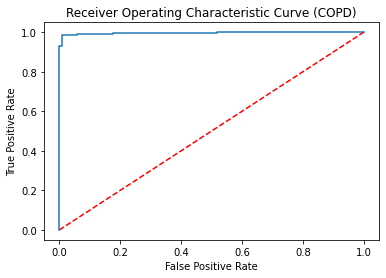

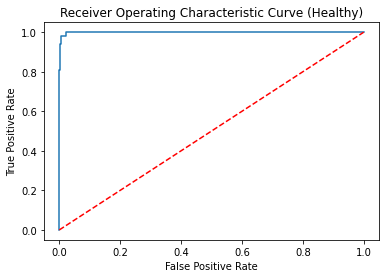

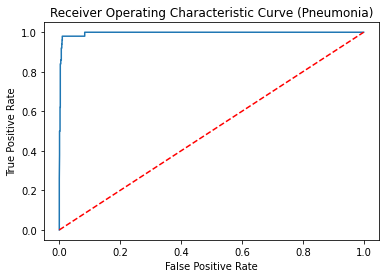

{'matrix': array([[1152,    5,   12],
       [   0,   49,    3],
       [   1,    0,   49]]), 'acc': 0.983477576711251, 'kappa': 0.89796082209377}


In [4]:
#@title Configuration
#@markdown ---
#@markdown Audio
data_url = "/content/drive/MyDrive/Audio ICBHI/processed_audio_files" #@param {type:"string"}
Features = "MFCC" #@param ["MFCC","GFCC","CD"] {type:"string"}
Number_F =  64#@param {type:"integer"}


#@markdown ---
#@markdown Classes
CORP = True #@param {type:"boolean"}
Pneumonia = True #@param {type:"boolean"}
Healthy = True #@param {type:"boolean"}
URTI = False #@param {type:"boolean"}
Asthma = False #@param {type:"boolean"}
LRTI = False #@param {type:"boolean"}
Bronchiectasis = False #@param {type:"boolean"}

#@markdown ---
#@markdown Classifier

Samplig_method = "DATA AUGMENTATION" #@param ["None", "ROS", "SMOTE", "SMOTE-ENN", "SMOTE-BL", "ADASYN", "DATA AUGMENTATION"] {type:"string"}
Classifier_method = "RNN" #@param ["MLP","CNN","RNN","QD"] {type:"string"}
Train_value = 80 #@param {type:"slider", min:0, max:100, step:1}
Epochs = 50 #@param {type:"slider", min:10, max:200, step:10}

#@markdown ---
#@markdown Results
Matrix_Train = False #@param {type:"boolean"}
Matrix_Test = True #@param {type:"boolean"}
ROC_Test = True #@param {type:"boolean"}

#@markdown ---
#@markdown Experimental
Seed = 32 #@param {type:"number"}

programa()

In [2]:
def list_class(CORP, Pneumonia,Healthy,URTI,Asthma,LRTI,Bronchiectasis):
  class_list=[]
  if CORP: class_list.append("COPD")
  if Pneumonia: class_list.append("Pneumonia")
  if Healthy:class_list.append("Healthy")
  if URTI:class_list.append("URTI")
  if Asthma:class_list.append("Asthma")
  if LRTI:class_list.append("LRTI")
  if Bronchiectasis:class_list.append("Bronchiectasis")
  return class_list


def list_samples(data_url, class_list):
  audio_file=[]
  audio_class=[]
  dises={
  '101' : 'URTI',
  '102' : 'Healthy',
  '103' : 'Asthma',
  '104' : 'COPD',
  '105' : 'URTI',
  '106' : 'COPD',
  '107' : 'COPD',
  '108' : 'LRTI',
  '109' : 'COPD',
  '110' : 'COPD',
  '111' : 'Bronchiectasis',
  '112' : 'COPD',
  '113' : 'COPD',
  '114' : 'COPD',
  '115' : 'LRTI',
  '116' : 'Bronchiectasis',
  '117' : 'COPD',
  '118' : 'COPD',
  '119' : 'URTI',
  '120' : 'COPD',
  '121' : 'Healthy',
  '122' : 'Pneumonia',
  '123' : 'Healthy',
  '124' : 'COPD',
  '125' : 'Healthy',
  '126' : 'Healthy',
  '127' : 'Healthy',
  '128' : 'COPD',
  '129' : 'URTI',
  '130' : 'COPD',
  '131' : 'URTI',
  '132' : 'COPD',
  '133' : 'COPD',
  '134' : 'COPD',
  '135' : 'Pneumonia',
  '136' : 'Healthy',
  '137' : 'URTI',
  '138' : 'COPD',
  '139' : 'COPD',
  '140' : 'Pneumonia',
  '141' : 'COPD',
  '142' : 'COPD',
  '143' : 'Healthy',
  '144' : 'Healthy',
  '145' : 'COPD',
  '146' : 'COPD',
  '147' : 'COPD',
  '148' : 'URTI',
  '149' : 'Bronchiolitis',
  '150' : 'URTI',
  '151' : 'COPD',
  '152' : 'Healthy',
  '153' : 'Healthy',
  '154' : 'COPD',
  '155' : 'COPD',
  '156' : 'COPD',
  '157' : 'COPD',
  '158' : 'COPD',
  '159' : 'Healthy',
  '160' : 'COPD',
  '161' : 'Bronchiolitis',
  '162' : 'COPD',
  '163' : 'COPD',
  '164' : 'URTI',
  '165' : 'URTI',
  '166' : 'COPD',
  '167' : 'Bronchiolitis',
  '168' : 'Bronchiectasis',
  '169' : 'Bronchiectasis',
  '170' : 'COPD',
  '171' : 'Healthy',
  '172' : 'COPD',
  '173' : 'Bronchiolitis',
  '174' : 'COPD',
  '175' : 'COPD',
  '176' : 'COPD',
  '177' : 'COPD',
  '178' : 'COPD',
  '179' : 'Healthy',
  '180' : 'COPD',
  '181' : 'COPD',
  '182' : 'Healthy',
  '183' : 'Healthy',
  '184' : 'Healthy',
  '185' : 'COPD',
  '186' : 'COPD',
  '187' : 'Healthy',
  '188' : 'URTI',
  '189' : 'COPD',
  '190' : 'URTI',
  '191' : 'Pneumonia',
  '192' : 'COPD',
  '193' : 'COPD',
  '194' : 'Healthy',
  '195' : 'COPD',
  '196' : 'Bronchiectasis',
  '197' : 'URTI',
  '198' : 'COPD',
  '199' : 'COPD',
  '200' : 'COPD',
  '201' : 'Bronchiectasis',
  '202' : 'Healthy',
  '203' : 'COPD',
  '204' : 'COPD',
  '205' : 'COPD',
  '206' : 'Bronchiolitis',
  '207' : 'COPD',
  '208' : 'Healthy',
  '209' : 'Healthy',
  '210' : 'URTI',
  '211' : 'COPD',
  '212' : 'COPD',
  '213' : 'COPD',
  '214' : 'Healthy',
  '215' : 'Bronchiectasis',
  '216' : 'Bronchiolitis',
  '217' : 'Healthy',
  '218' : 'COPD',
  '219' : 'Pneumonia',
  '220' : 'COPD',
  '221' : 'COPD',
  '222' : 'COPD',
  '223' : 'COPD',
  '224' : 'Healthy',
  '225' : 'Healthy',
  '226' : 'Pneumonia'}

  contenido= os.listdir(data_url)
  for con in tqdm(contenido, desc="Data Collector          ",ncols=90, colour="Blue"):
    if ".wav" in con:
      if dises[con.split("_")[0]] in class_list:
        audio_file.append(con)
        audio_class.append(dises[con.split("_")[0]])

  #eje_x = class_list
  #eje_y = []
  #for c in class_list:
  #  eje_y.append(Counter(audio_class)[c])
  #plt.bar(eje_x, eje_y, color="blue")
  #plt.ylabel("Samples")
  #plt.xlabel("Class")  
  #plt.show()
  return audio_file, audio_class


def Features_extractor(audio_file, Samplig_method, Features, type_tt):
    augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.5, max_rate=2, p=0.5),
    ])

    soundArr,sample_rate=lb.load(data_url+"/"+audio_file)
    if Samplig_method == "DATA AUGMENTATION" and type_tt=="TRAIN":
      soundArr = augment(samples=soundArr, sample_rate=sample_rate)

    if Features=="MFCC":
      features_=lb.feature.mfcc(y=soundArr,sr=sample_rate, n_mfcc=Number_F)
    elif Features=="GFCC":
      features_= np.transpose(gfcc.gfcc(soundArr,22050, win_len=1, num_ceps=Number_F, nfilts=128))
    elif Features=="CD":
      mfcc_=lb.feature.mfcc(y=soundArr,sr=sample_rate, n_mfcc=Number_F)
      gfcc_=np.transpose(gfcc.gfcc(soundArr,22050, win_len=1, num_ceps=Number_F, nfilts=128))
      cd_mfcc=np.mean(mfcc_,1)
      cd_gfcc=np.mean(gfcc_,1)
      features_= np.hstack((cd_mfcc,cd_gfcc))
    return features_

def Train_Test(audio_file, audio_class):
  le=LabelEncoder()
  clas_audio=le.fit_transform(audio_class)
  audios_train,audios_test,y_train,y_test=train_test_split(audio_file,clas_audio,test_size=1-(Train_value/100), random_state=Seed)
  return audios_train,audios_test,y_train,y_test,le

def Train_features(audios_train,y_train):
  data_train=[]
  clas_train=[]
  for i in tqdm(range(len(audios_train)), desc="Feature Extraction Train",ncols=90, colour="Blue"):
    try:
      data_train.append(Features_extractor(audios_train[i], Samplig_method, Features, "TRAIN"))
      clas_train.append(y_train[i])
    except:
      pass
  data_train=tf.convert_to_tensor(data_train)
  clas_train=tf.convert_to_tensor(clas_train)
  return data_train,clas_train

def Test_features(audios_test,y_test):
  data_test=[]
  clas_test=[]
  for i in tqdm(range(len(audios_test)), desc="Feature Extraction Test ",ncols=90, colour="Blue"):
    try:
      data_test.append(Features_extractor(audios_test[i], Samplig_method, Features, "TEST"))
      clas_test.append(y_test[i])
    except:
      pass
  data_test=tf.convert_to_tensor(data_test)
  clas_test=tf.convert_to_tensor(clas_test)
  return data_test,clas_test

def MLP_train(x_train_s, y_train_s,x_test, y_test):
  my_callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=5),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=0.00001,mode='min')
        ]

  tf.keras.backend.clear_session()
  input=tf.keras.layers.Input(shape=(x_train_s.shape[1],x_train_s.shape[2],1), name="Input_Spectro")

  x= tf.keras.layers.Flatten()(input)
  x= tf.keras.layers.BatchNormalization()(x)
  x= tf.keras.layers.Dense(20,activation='relu', name="Dense_1")(x)
  x= tf.keras.layers.Dropout(0.2, name="Dropout_1")(x)

  x= tf.keras.layers.Dense(10,activation='relu', name="Dense_2")(x)
  x= tf.keras.layers.Dropout(0.2, name="Dropout_2")(x)

  x= tf.keras.layers.Dense(6,activation='relu', name="Dense_3")(x)
  x= tf.keras.layers.Dropout(0.2, name="Dropout_3")(x)

  x= tf.keras.layers.Dense(5,activation='relu', name="Dense_5")(x)
  x= tf.keras.layers.Dense(4,activation='relu', name="Dense_8")(x)

  output= tf.keras.layers.Dense(np.max(y_train_s)+1,activation='softmax', name="Dense_9")(x)
  MLP=tf.keras.Model(input, output, name="Output")
  MLP.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history=MLP.fit(
      x_train_s,
      y_train_s,
      validation_data=(x_test,y_test),
      #batch=32,
      epochs=Epochs,verbose=1,
      callbacks=my_callbacks
  )
  predict_test_=MLP.predict(x_test)
  predict_test=np.argmax(predict_test_, axis=1)
  cm = confusion_matrix(y_test, predict_test)
  acc=accuracy_score(y_test, predict_test) 
  kappa = cohen_kappa_score(y_test, predict_test)

  sort_list=np.sort(class_list)
  for i in range(np.max(predict_test)+1):
    #print("Class",i)
    n_y=tf.cast(y_test==i,dtype=tf.int16)
    roc=roc_curve(n_y.numpy(), predict_test_[:,i])
    plt.plot(roc[0],roc[1])
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve'+" ("+sort_list[i]+")")
    plt.show()

  results={"matrix":cm,"acc":acc,"kappa":kappa}
  return results


def CNN_train(x_train_s, y_train_s,x_test, y_test):
  my_callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=5),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=0.00001,mode='min')
        ]

  tf.keras.backend.clear_session()
  input=tf.keras.layers.Input(shape=(x_train_s.shape[1],x_train_s.shape[2],1), name="Input_Spectro")
  x= tf.keras.layers.Conv2D(16,(2,2), name="Conv2D_1")(input)
  x= tf.keras.layers.Activation(tf.keras.activations.relu, name="Activation_1")(x)
  x= tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid', name="MaxPooling_1")(x)
  x= tf.keras.layers.Dropout(0.2, name="Dropout_1")(x)

  x= tf.keras.layers.Conv2D(32,(2,2), name="Conv2D_2")(x)
  x= tf.keras.layers.Activation(tf.keras.activations.relu, name="Activation_2")(x)
  x= tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid', name="MaxPooling_2")(x)
  x= tf.keras.layers.Dropout(0.2, name="Dropout_2")(x)

  x= tf.keras.layers.Conv2D(64,(2,2), name="Conv2D_3")(x)
  x= tf.keras.layers.Activation(tf.keras.activations.relu, name="Activation_3")(x)
  x= tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid', name="MaxPooling_3")(x)
  x= tf.keras.layers.Dropout(0.2, name="Dropout_3")(x)

  x= tf.keras.layers.Conv2D(128,(2,2), name="Conv2D_4")(x)
  x= tf.keras.layers.Activation(tf.keras.activations.relu, name="Activation_4")(x)
  x= tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid', name="MaxPooling_4")(x)
  x= tf.keras.layers.Dropout(0.2, name="Dropout_4")(x)

  x= tf.keras.layers.GlobalAveragePooling2D(name="AveragePooling2D")(x)
  output= tf.keras.layers.Dense(np.max(y_train_s)+1, name="Dense", activation="softmax")(x)

  CNN=tf.keras.Model(input, output, name="Output")
  CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  history=CNN.fit(
      x_train_s,
      y_train_s,
      validation_data=(x_test,y_test),
      epochs=Epochs,verbose=1,batch_size=16,
      callbacks=my_callbacks
  )

  predict_test_=CNN.predict(x_test)
  predict_test=np.argmax(predict_test_, axis=1)
  cm = confusion_matrix(y_test, predict_test)
  acc=accuracy_score(y_test, predict_test) 
  #recall=recall_score(y_test, predict_test)
  kappa = cohen_kappa_score(y_test, predict_test)

  sort_list=np.sort(class_list)
  for i in range(np.max(predict_test)+1):
    #print("Class",i)
    n_y=tf.cast(y_test==i,dtype=tf.int16)
    roc=roc_curve(n_y.numpy(), predict_test_[:,i],)
    plt.plot(roc[0],roc[1])
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve'+" ("+sort_list[i]+")")
    plt.show()

  results={"matrix":cm,"acc":acc,"kappa":kappa}
  return results



def RNN_train(x_train_s, y_train_s,x_test, y_test):
  my_callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=5),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=0.00001,mode='min')
        ]
  tf.keras.backend.clear_session()
  input=tf.keras.layers.Input(shape=(x_train_s.shape[1],x_train_s.shape[2],1), name="Input_Spectro")
  x=tf.keras.layers.BatchNormalization()(input)
  x=tf.keras.layers.Conv2D(64,(4,1),padding='same')(x)
  x= tf.keras.layers.Activation(tf.keras.activations.relu, name="Activation_1")(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x= tf.keras.layers.AveragePooling2D(pool_size=(2,1),padding='same', name="MaxPooling_1")(x)
  x= tf.keras.layers.Dropout(0.1, name="Dropout_1")(x)

  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Conv2D(128,(4,1),padding='same')(x)
  x= tf.keras.layers.Activation(tf.keras.activations.relu, name="Activation_2")(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x= tf.keras.layers.AveragePooling2D(pool_size=(2,1),padding='same', name="MaxPooling_2")(x)
  x= tf.keras.layers.Dropout(0.15, name="Dropout_2")(x)

  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Conv2D(256,(4,1),padding='same')(x)
  x= tf.keras.layers.Activation(tf.keras.activations.relu, name="Activation_3")(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x= tf.keras.layers.AveragePooling2D(pool_size=(4,1),padding='same', name="MaxPooling_3")(x)
  x= tf.keras.layers.Dropout(0.2, name="Dropout_3")(x)

  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Conv2D(512,(4,1),padding='same')(x)
  x= tf.keras.layers.Activation(tf.keras.activations.relu, name="Activation_4")(x)
  x= tf.keras.layers.BatchNormalization()(x)
  x= tf.keras.layers.AveragePooling2D(pool_size=(4,1),padding='same', name="MaxPooling_4")(x)
  x= tf.keras.layers.Dropout(0.25, name="Dropout_4")(x)
  x= tf.squeeze(x,axis=1)

  x=tf.keras.layers.Bidirectional(tf.keras.layers.GRU((256),return_sequences=True))(x)
  x= tf.expand_dims(x,-1)
  x= tf.keras.layers.AveragePooling2D(pool_size=(1,512),padding='same', name="MaxPooling_5")(x)
  x= tf.keras.layers.Flatten()(x)

  x= tf.keras.layers.Dense(256,activation='relu', name="Dense_1")(x)
  x= tf.keras.layers.Dropout(0.3, name="Dropout_5")(x)

  x= tf.keras.layers.Dense(1024,activation='relu', name="Dense_2")(x)
  x= tf.keras.layers.Dropout(0.3, name="Dropout_6")(x)

  x= tf.keras.layers.Dense(1024,activation='relu', name="Dense_3")(x)
  x= tf.keras.layers.Dropout(0.3, name="Dropout_7")(x)

  output= tf.keras.layers.Dense(np.max(y_train_s)+1,activation='softmax', name="Dense_4")(x)


  RNN=tf.keras.Model(input, output, name="Output")
  RNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #K.set_value(CNN.optimizer.learning_rate, 0.001)

  history=RNN.fit(
      x_train_s,
      y_train_s,
      validation_data=(x_test,y_test),
      epochs=Epochs,verbose=1,batch_size=64,
      callbacks=my_callbacks
  )
  predict_test_=RNN.predict(x_test)
  predict_test=np.argmax(predict_test_, axis=1)
  cm = confusion_matrix(y_test, predict_test)
  acc=accuracy_score(y_test, predict_test) 
  kappa = cohen_kappa_score(y_test, predict_test)

  sort_list=np.sort(class_list)
  for i in range(np.max(predict_test)+1):
    #print("Class",i)
    n_y=tf.cast(y_test==i,dtype=tf.int16)
    roc=roc_curve(n_y.numpy(), predict_test_[:,i])
    plt.plot(roc[0],roc[1])
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve'+" ("+sort_list[i]+")")
    plt.show()

  results={"matrix":cm,"acc":acc,"kappa":kappa}
  return results


def MLP_cd_train(x_train_s, y_train_s,x_test, y_test):
  my_callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=5),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=0.00001,mode='min')
        ]
  tf.keras.backend.clear_session()
  input=tf.keras.layers.Input(shape=(x_train_s.shape[1]), name="Input_Spectro")
  #x= tf.keras.layers.Flatten()(input)
  x= tf.keras.layers.BatchNormalization()(input)
  x= tf.keras.layers.Dense(20,activation='relu', name="Dense_1")(x)
  x= tf.keras.layers.Dropout(0.2, name="Dropout_1")(x)

  x= tf.keras.layers.Dense(10,activation='relu', name="Dense_2")(x)
  x= tf.keras.layers.Dropout(0.2, name="Dropout_2")(x)

  x= tf.keras.layers.Dense(6,activation='relu', name="Dense_3")(x)
  x= tf.keras.layers.Dropout(0.2, name="Dropout_3")(x)

  x= tf.keras.layers.Dense(5,activation='relu', name="Dense_5")(x)

  x= tf.keras.layers.Dense(4,activation='relu', name="Dense_8")(x)
  output= tf.keras.layers.Dense(np.max(y_train_s)+1,activation='softmax', name="Dense_9")(x)

  MLP=tf.keras.Model(input, output, name="Output")

  MLP.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  history=MLP.fit(
      x_train_s,
      y_train_s,
      validation_data=(x_test,y_test),
      #batch=32,
      epochs=Epochs,verbose=1,
      callbacks=my_callbacks
  )

  predict_test_=MLP.predict(x_test)
  predict_test=np.argmax(predict_test_, axis=1)
  cm = confusion_matrix(y_test, predict_test)
  acc=accuracy_score(y_test, predict_test) 
  #recall=recall_score(y_test, predict_test)
  kappa = cohen_kappa_score(y_test, predict_test)

  sort_list=np.sort(class_list)
  for i in range(np.max(predict_test)+1):
    #print("Class",i)
    n_y=tf.cast(y_test==i,dtype=tf.int16)
    roc=roc_curve(n_y.numpy(), predict_test_[:,i])
    plt.plot(roc[0],roc[1])
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve'+" ("+sort_list[i]+")")
    plt.show()

  results={"matrix":cm,"acc":acc,"kappa":kappa}
  return results


def QD_train(x_train_s, y_train_s,x_test, y_test):
  clf = QuadraticDiscriminantAnalysis()
  clf.fit(x_train_s, y_train_s)  
  predict_test=clf.predict(x_test)
  cm = confusion_matrix(y_test, predict_test)
  
  acc=accuracy_score(y_test, predict_test) 
  kappa = cohen_kappa_score(y_test, predict_test)
  results={"matrix":cm,"acc":acc,"kappa":kappa}
  return results


In [3]:
global class_list
def programa():
  global class_list

  class_list=list_class(CORP, Pneumonia,Healthy,URTI,Asthma,LRTI,Bronchiectasis)
  audio_file, audio_class=list_samples(data_url, class_list)
  print()
  audios_train,audios_test,y_train,y_test,le=Train_Test(audio_file, audio_class)
  if Samplig_method=="DATA AUGMENTATION" or Samplig_method=="ROS":
    ros = RandomOverSampler()
    audios_train, y_train = ros.fit_resample(np.array(audios_train).reshape((-1,1)), y_train)
    audios_train=audios_train.reshape(-1)
  x_train,y_train=Train_features(audios_train,y_train)
  print()
  x_test,y_test=Test_features(audios_test,y_test)
  print()

  if Features== "MFCC" or Features== "GFCC":
      if Samplig_method=="None" or Samplig_method=="DATA AUGMENTATION" or Samplig_method=="ROS":
          x_train_s=x_train
          y_train_s=y_train

      elif Samplig_method=="SMOTE":
          x_train_reshape=np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
          smote = SMOTE()
          x_train_s, y_train_s = smote.fit_resample(x_train_reshape, y_train)
          x_train_s=np.reshape(x_train_s,(x_train_s.shape[0],x_train.shape[1],x_train.shape[2]))

      elif Samplig_method=="ADASYN":
          x_train_reshape=np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
          adasyn = ADASYN()
          x_train_s, y_train_s = adasyn.fit_resample(x_train_reshape, y_train)
          x_train_s=np.reshape(x_train_s,(x_train_s.shape[0],x_train.shape[1],x_train.shape[2]))

      elif Samplig_method=="SMOTE-ENN":
          x_train_reshape=np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
          smoteenn = SMOTEENN(n_jobs=-1)
          x_train_s, y_train_s = smoteenn.fit_resample(x_train_reshape, y_train)
          x_train_s=np.reshape(x_train_s,(x_train_s.shape[0],x_train.shape[1],x_train.shape[2]))

      elif Samplig_method=="SMOTE-BL":
          x_train_reshape=np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
          smotebl = BorderlineSMOTE()
          x_train_s, y_train_s = smotebl.fit_resample(x_train_reshape, y_train)
          x_train_s=np.reshape(x_train_s,(x_train_s.shape[0],x_train.shape[1],x_train.shape[2]))

      x_test=np.expand_dims(x_test,-1)
      x_train_s=np.expand_dims(x_train_s,-1)
      
  elif Features=="CD":
      if Samplig_method=="None" or Samplig_method=="DATA AUGMENTATION" or Samplig_method=="ROS":
          x_train_s=x_train
          y_train_s=y_train
      elif Samplig_method=="SMOTE":
          smote = SMOTE()
          x_train_s, y_train_s = smote.fit_resample(x_train, y_train)

      elif Samplig_method=="ADASYN":
          adasyn = ADASYN()
          x_train_s, y_train_s = adasyn.fit_resample(x_train, y_train)

      elif Samplig_method=="SMOTE-ENN":
          smoteenn = SMOTEENN()
          x_train_s, y_train_s = smoteenn.fit_resample(x_train, y_train)

      elif Samplig_method=="SMOTE-BL":
          smotebl = BorderlineSMOTE()
          x_train_s, y_train_s = smotebl.fit_resample(x_train, y_train)
  print("Sampling_method         :","COMPLETE")
  print()

  if Features!="CD":
    if Classifier_method=="MLP":
      print("MLP training")
      print()
      metrics=MLP_train(x_train_s, y_train_s,x_test, y_test)
    elif Classifier_method=="CNN":
      print("CNN training")
      print()
      metrics=CNN_train(x_train_s, y_train_s,x_test, y_test)
    elif Classifier_method=="RNN":
      print("RNN training")
      print()
      metrics=RNN_train(x_train_s, y_train_s,x_test, y_test)
  else:
    if Classifier_method=="MLP":
      print("MLP training")
      print()
      metrics=MLP_cd_train(x_train_s, y_train_s,x_test, y_test)
    if Classifier_method=="QD":
      print("QD training")
      print()
      metrics=QD_train(x_train_s, y_train_s,x_test, y_test)
  print(metrics)